### Deep Q Learning from Gerone's book

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf                   
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Input
from tensorflow.keras.optimizers import Adam
import gym
import random
from collections import deque

In [2]:
env = gym.make('CartPole-v1' , render_mode = 'rgb_array')

In [3]:
input_shape = env.observation_space.shape
n_outputs = env.action_space.n

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32,activation='elu',input_shape=input_shape),
    tf.keras.layers.Dense(32,activation='elu'),
    tf.keras.layers.Dense(n_outputs)
])

/Users/User/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
def epsilon_greedy_policy(state,epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis],verbose=0)[0]
        return Q_values.argmax()

In [6]:
replay_buffer = deque(maxlen=2000) #double ended queue
# store past experiences in a replay memory and sample a random batch at each training iteration
# helps reduce the correlations between the experiences in a training batch

In [7]:
# Experience = state, action, resulting reward, next state, done, truncated
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer),size=batch_size)
    batch = [replay_buffer[index]for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]

In [8]:
# single step
def play_one_step(env,state,epsilon):
    action = epsilon_greedy_policy(state,epsilon)
    next_state,reward,done,truncated,info = env.step(action)
    replay_buffer.append((state,action,reward,next_state,done,truncated))
    return next_state,reward,done,truncated,info

In [9]:
# training func
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.MeanSquaredError()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states , actions , rewards , next_states , dones , truncateds = experiences
    next_Q_values = model.predict(next_states,verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1,1)
    mask = tf.one_hot(actions,n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask , axis = 1 , keepdims = True)
        loss = tf.reduce_mean(loss_fn(target_Q_values,Q_values))
    grads = tape.gradient(loss , model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))

In [12]:
# training
episodes = 200
Rs = []
for episode in range(episodes):
    print(f'Episode {episode}')
    rewards_of_episode = 0
    obs , info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode/episodes , 0.01)
        obs , reward , done , truncated , info = play_one_step(env , obs , epsilon)
        rewards_of_episode += reward
        if done or truncated:
            break
    Rs.append(rewards_of_episode)
    if episode > 50:
        training_step(batch_size)

Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71
Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 78
Episode 79
Episode 80
Episode 81
Episode 82
Episode 83
Episode 84
Episode 85
Episode 86
Episode 87
Episode 88
Episode 89
Episode 90
Episode 9

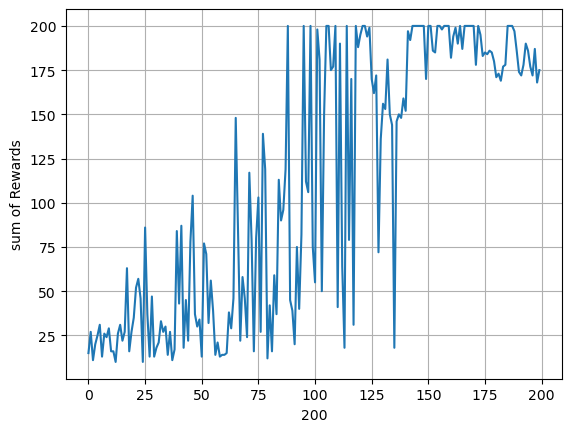

(188.54, 10.684961394408498)

In [19]:
plt.plot(Rs)
plt.ylabel('sum of Rewards')
plt.xlabel(episodes)
plt.grid()
plt.show()
np.mean(Rs[150:]), np.std(Rs[150:])

In [1]:
# EOF